In [2]:
import numpy as np
import pandas as pd
import os 
import sys
import glob
import time
import matplotlib.pyplot as plt

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import drt
from stan_models import save_pickle,load_pickle
import eis_utils as gt

%load_ext autoreload
%autoreload 2

# Simulated data

In [3]:
dr = drt.DRT()
files = glob.glob('../data/simulated/Z_*.csv')
files = [f for f in files if f.find('trunc')==-1]
# fit one file to generate A matrices
df = pd.read_csv(files[0])
Z = df['Zreal'] + 1j*df['Zimag']
dr.ridge_fit(df['Freq'].values,Z.values)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
../bayes-drt\drt.py:1049: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


In [802]:
"MAP fits"
# tau for plotting
tau_plot = np.logspace(-7,2,200)
start = time.time()

for file in files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):]
    Zoutfile = os.path.join('map_results',f'Zout{suffix}')
    Goutfile = os.path.join('map_results',f'Gout{suffix}')
    pkl = os.path.join('map_results','obj{}.pkl'.format(suffix[:-4]))
    if file.split('_')[2]=='noiseless.csv':
        sigma_min=0.005
    else:
        sigma_min=0.002
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        df = pd.read_csv(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values
        # fit
        file_start = time.time()
        dr.map_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=False,sigma_min=sigma_min)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        # save results
        Z_pred = dr.predict(df['Freq'].values)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])
        Z_res['sigma_re'] = dr._opt_result['sigma_tot'][:len(df)]*dr._Z_scale
        Z_res['sigma_im'] = dr._opt_result['sigma_tot'][len(df):]*dr._Z_scale
        
        g_pred = dr.drt(eval_tau=tau_plot)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)
        
        # pickle the drt object for access to all other attributes
        save_pickle(dr,pkl)
        
print('================================')        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../data/simulated\Z_2RC_Macdonald_0.25.csv
-------------------------------
File fit time: 12.71 seconds


../bayes-drt\stan_models.py:7: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


Dumped pickle to map_results\obj_2RC_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_2RC_Macdonald_1.0.csv
-------------------------------
File fit time: 6.97 seconds
Dumped pickle to map_results\obj_2RC_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_2RC_Macdonald_2.5.csv
-------------------------------
File fit time: 3.50 seconds
Dumped pickle to map_results\obj_2RC_Macdonald_2.5.pkl
-------------------------------
../data/simulated\Z_2RC_noiseless.csv
-------------------------------
Already ran
-------------------------------
../data/simulated\Z_2RC_Orazem_0.25.csv
-------------------------------
File fit time: 17.38 seconds
Dumped pickle to map_results\obj_2RC_Orazem_0.25.pkl
-------------------------------
../data/simulated\Z_2RC_Orazem_1.0.csv
-------------------------------
File fit time: 4.86 seconds
Dumped pickle to map_results\obj_2RC_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_2RC_Orazem_2.5.csv
------------

Dumped pickle to map_results\obj_ZARC-RL_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_Orazem_2.5.csv
-------------------------------
File fit time: 1.32 seconds
Dumped pickle to map_results\obj_ZARC-RL_Orazem_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_uniform_0.25.csv
-------------------------------
File fit time: 4.56 seconds
Dumped pickle to map_results\obj_ZARC-RL_uniform_0.25.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_uniform_1.0.csv
-------------------------------
File fit time: 2.10 seconds
Dumped pickle to map_results\obj_ZARC-RL_uniform_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_uniform_2.5.csv
-------------------------------
File fit time: 2.01 seconds
Dumped pickle to map_results\obj_ZARC-RL_uniform_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC_Macdonald_0.25.csv
-------------------------------
File fit time: 5.87 seconds
Dumped pickle to map_results\obj_ZAR

File fit time: 12.55 seconds


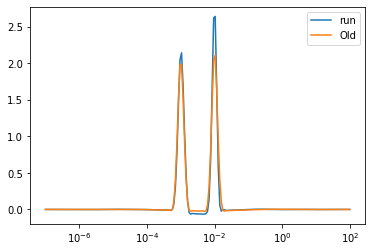

In [861]:
pkl = load_pickle('map_results/obj_2ZARC_noiseless.pkl')
file = '../data/simulated/Z_2RC_Macdonald_0.25.csv'
df = pd.read_csv(file)
# df = df.sort_values('Freq')
Z = df['Zreal'].values + 1j*df['Zimag'].values
# fit
file_start = time.time()
dr.map_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=False,outliers=False,max_iter=30e3,sigma_min=0.002)
print('File fit time: {:.2f} seconds'.format(time.time()-file_start))

suffix = file[file.find('_'):]
gres = pd.read_csv(os.path.join('map_results','Gout{}'.format(suffix)))

old_res = pd.read_csv(os.path.join('map_results/old','Gout{}'.format(suffix)))

tau_plot = np.logspace(-7,2,200)
plt.plot(tau_plot,dr.drt(tau_plot),label='run')
# plt.plot(gres['tau'],gres['gamma'],label='New')
plt.plot(old_res['tau'],old_res['gamma'],label='Old')
plt.xscale('log')
plt.legend()

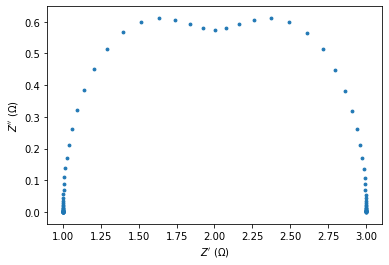

In [788]:
gt.plot_nyquist(df)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021461C23988>,
      dtype=object)

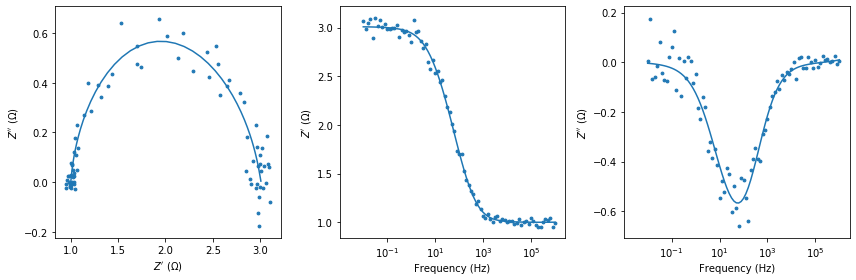

In [469]:
fig,axes = plt.subplots(1,3,figsize=(12,4))
gt.plot_full_eis(df,axes=axes,bode_cols=['Zreal','Zimag'])

df_pred = gt.construct_eis_df(df['Freq'],dr.predict(df['Freq']))
gt.plot_full_eis(df_pred,axes=axes,bode_cols=['Zreal','Zimag'],plot_func='plot')

(0, 0.06019372701960001)

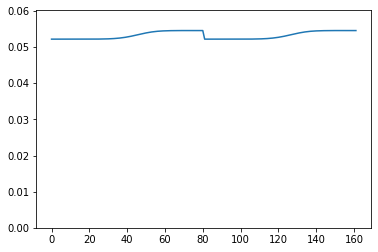

In [476]:
fig,ax = plt.subplots()
ax.plot(dr._opt_result['sigma_tot'])
ax.set_ylim(0,ax.get_ylim()[1]*1.1)

In [473]:
dr._opt_result

OrderedDict([('hfr_raw', array(0.01161937)),
             ('induc', array(2.07573072e-14)),
             ('beta',
              array([-2.99673347e-04, -4.96894444e-04, -6.75746754e-04, -8.16147879e-04,
                     -9.24234028e-04, -1.00472077e-03, -1.06359648e-03, -1.10412760e-03,
                     -1.12709188e-03, -1.12992566e-03, -1.10612430e-03, -1.04624562e-03,
                     -9.38599572e-04, -7.66484097e-04, -5.11655482e-04, -1.50261454e-04,
                      3.44104831e-04,  1.00115337e-03,  1.85612457e-03,  2.95089196e-03,
                      4.33778679e-03,  6.08332487e-03,  8.27520521e-03,  1.10241206e-02,
                      1.44804073e-02,  1.88335552e-02,  2.43235186e-02,  3.12450493e-02,
                      3.99465247e-02,  5.07837867e-02,  6.40937871e-02,  8.01093160e-02,
                      9.88844987e-02,  1.20267410e-01,  1.43819818e-01,  1.68858259e-01,
                      1.94313468e-01,  2.18879882e-01,  2.41131317e-01,  2.59758175e-

calculating A


../bayes-drt\drt.py:913: RuntimeWarning: overflow encountered in exp
  return func


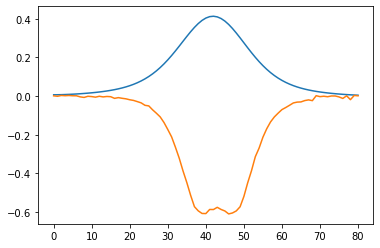

In [48]:
plt.plot(dr.predict(df['Freq'].values).imag)
plt.plot(df['Zimag'])

In [878]:
"MCMC sampling"
# tau for plotting
tau_plot = np.logspace(-7,2,200)
start = time.time()

for file in files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):]
    Zoutfile = os.path.join('bayes_results',f'Zout{suffix}')
    Goutfile = os.path.join('bayes_results',f'Gout{suffix}')
    pkl = os.path.join('bayes_results','obj{}.pkl'.format(suffix[:-4]))
    if file.split('_')[2]=='noiseless.csv':
        sigma_min=0.005
    else:
        sigma_min=0.002
        
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        df = pd.read_csv(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values
        
        # fit
        file_start = time.time()
        dr.bayes_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=True,sigma_min=sigma_min)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        Z_pred = dr.predict(df['Freq'].values)
        # Z credibility interval
        Z_lo = dr.predict(df['Freq'].values,percentile=2.5)
        Z_hi = dr.predict(df['Freq'].values,percentile=97.5)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag,Z_lo,Z_hi]).T,
                             columns=['freq','Zreal','Zimag','Zlo','Zhi'])
        Z_res['sigma_re'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[:len(df)]*dr._Z_scale
        Z_res['sigma_im'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[len(df):]*dr._Z_scale
        
        g_pred = dr.drt(eval_tau=tau_plot)
        # drt credibility interval
        g_lo = dr.drt(eval_tau=tau_plot,percentile=2.5)
        g_hi = dr.drt(eval_tau=tau_plot,percentile=97.5)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred,g_lo,g_hi]).T,
                             columns=['tau','gamma','gamma_lo','gamma_hi'])
        
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)
        
        # pickle the drt object for access to all other attributes
        save_pickle(dr,pkl)
        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../data/simulated\Z_2RC_Macdonald_0.25.csv
-------------------------------


../bayes-drt\drt.py:311: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 129.66 seconds


../bayes-drt\stan_models.py:7: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


Dumped pickle to bayes_results\obj_2RC_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_2RC_Macdonald_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 71.71 seconds
Dumped pickle to bayes_results\obj_2RC_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_2RC_Macdonald_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 72.95 seconds
Dumped pickle to bayes_results\obj_2RC_Macdonald_2.5.pkl
-------------------------------
../data/simulated\Z_2RC_noiseless.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 129.19 seconds
Dumped pickle to bayes_results\obj_2RC_noiseless.pkl
-------------------------------
../data/simulated\Z_2RC_Orazem_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 128.51 seconds
Dumped pickle to bayes_results\obj_2RC_Orazem_0.25.pkl
-------------------------------
../data/simulated\Z_2RC_Orazem_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 69.31 seconds
Dumped pickle to bayes_results\obj_2RC_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_2RC_Orazem_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 68.82 seconds
Dumped pickle to bayes_results\obj_2RC_Orazem_2.5.pkl
-------------------------------
../data/simulated\Z_2RC_uniform_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 129.56 seconds
Dumped pickle to bayes_results\obj_2RC_uniform_0.25.pkl
-------------------------------
../data/simulated\Z_2RC_uniform_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 94.12 seconds
Dumped pickle to bayes_results\obj_2RC_uniform_1.0.pkl
-------------------------------
../data/simulated\Z_2RC_uniform_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 64.35 seconds
Dumped pickle to bayes_results\obj_2RC_uniform_2.5.pkl
-------------------------------
../data/simulated\Z_2ZARC_Macdonald_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 67.48 seconds
Dumped pickle to bayes_results\obj_2ZARC_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_2ZARC_Macdonald_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 65.59 seconds
Dumped pickle to bayes_results\obj_2ZARC_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_2ZARC_Macdonald_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 68.51 seconds
Dumped pickle to bayes_results\obj_2ZARC_Macdonald_2.5.pkl
-------------------------------
../data/simulated\Z_2ZARC_noiseless.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 81.96 seconds
Dumped pickle to bayes_results\obj_2ZARC_noiseless.pkl
-------------------------------
../data/simulated\Z_2ZARC_Orazem_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 66.42 seconds
Dumped pickle to bayes_results\obj_2ZARC_Orazem_0.25.pkl
-------------------------------
../data/simulated\Z_2ZARC_Orazem_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 68.83 seconds
Dumped pickle to bayes_results\obj_2ZARC_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_2ZARC_Orazem_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 65.04 seconds
Dumped pickle to bayes_results\obj_2ZARC_Orazem_2.5.pkl
-------------------------------
../data/simulated\Z_2ZARC_uniform_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 71.09 seconds
Dumped pickle to bayes_results\obj_2ZARC_uniform_0.25.pkl
-------------------------------
../data/simulated\Z_2ZARC_uniform_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 68.85 seconds
Dumped pickle to bayes_results\obj_2ZARC_uniform_1.0.pkl
-------------------------------
../data/simulated\Z_2ZARC_uniform_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 64.74 seconds
Dumped pickle to bayes_results\obj_2ZARC_uniform_2.5.pkl
-------------------------------
../data/simulated\Z_Gerischer_Macdonald_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 86.78 seconds
Dumped pickle to bayes_results\obj_Gerischer_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_Gerischer_Macdonald_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 62.65 seconds
Dumped pickle to bayes_results\obj_Gerischer_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_Gerischer_Macdonald_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 66.83 seconds
Dumped pickle to bayes_results\obj_Gerischer_Macdonald_2.5.pkl
-------------------------------
../data/simulated\Z_Gerischer_noiseless.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 108.52 seconds
Dumped pickle to bayes_results\obj_Gerischer_noiseless.pkl
-------------------------------
../data/simulated\Z_Gerischer_Orazem_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 88.28 seconds
Dumped pickle to bayes_results\obj_Gerischer_Orazem_0.25.pkl
-------------------------------
../data/simulated\Z_Gerischer_Orazem_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 60.61 seconds
Dumped pickle to bayes_results\obj_Gerischer_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_Gerischer_Orazem_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 69.56 seconds
Dumped pickle to bayes_results\obj_Gerischer_Orazem_2.5.pkl
-------------------------------
../data/simulated\Z_Gerischer_uniform_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 88.00 seconds
Dumped pickle to bayes_results\obj_Gerischer_uniform_0.25.pkl
-------------------------------
../data/simulated\Z_Gerischer_uniform_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 65.77 seconds
Dumped pickle to bayes_results\obj_Gerischer_uniform_1.0.pkl
-------------------------------
../data/simulated\Z_Gerischer_uniform_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 66.98 seconds
Dumped pickle to bayes_results\obj_Gerischer_uniform_2.5.pkl
-------------------------------
../data/simulated\Z_RC_Macdonald_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 125.42 seconds
Dumped pickle to bayes_results\obj_RC_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_RC_Macdonald_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 85.57 seconds
Dumped pickle to bayes_results\obj_RC_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_RC_Macdonald_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 69.17 seconds
Dumped pickle to bayes_results\obj_RC_Macdonald_2.5.pkl
-------------------------------
../data/simulated\Z_RC_noiseless.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 125.47 seconds
Dumped pickle to bayes_results\obj_RC_noiseless.pkl
-------------------------------
../data/simulated\Z_RC_Orazem_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 130.76 seconds
Dumped pickle to bayes_results\obj_RC_Orazem_0.25.pkl
-------------------------------
../data/simulated\Z_RC_Orazem_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 110.41 seconds
Dumped pickle to bayes_results\obj_RC_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_RC_Orazem_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 77.72 seconds
Dumped pickle to bayes_results\obj_RC_Orazem_2.5.pkl
-------------------------------
../data/simulated\Z_RC_uniform_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 133.29 seconds
Dumped pickle to bayes_results\obj_RC_uniform_0.25.pkl
-------------------------------
../data/simulated\Z_RC_uniform_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 129.10 seconds
Dumped pickle to bayes_results\obj_RC_uniform_1.0.pkl
-------------------------------
../data/simulated\Z_RC_uniform_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 82.65 seconds
Dumped pickle to bayes_results\obj_RC_uniform_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_Macdonald_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 67.29 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_Macdonald_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 63.84 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_Macdonald_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 64.19 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_Macdonald_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_noiseless.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 92.96 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_noiseless.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_Orazem_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 92.39 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_Orazem_0.25.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_Orazem_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 66.29 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_Orazem_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 72.69 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_Orazem_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_uniform_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 87.72 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_uniform_0.25.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_uniform_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 61.68 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_uniform_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC-RL_uniform_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 71.48 seconds
Dumped pickle to bayes_results\obj_ZARC-RL_uniform_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC_Macdonald_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 67.68 seconds
Dumped pickle to bayes_results\obj_ZARC_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_ZARC_Macdonald_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 68.63 seconds
Dumped pickle to bayes_results\obj_ZARC_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC_Macdonald_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 61.94 seconds
Dumped pickle to bayes_results\obj_ZARC_Macdonald_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC_noiseless.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 92.20 seconds
Dumped pickle to bayes_results\obj_ZARC_noiseless.pkl
-------------------------------
../data/simulated\Z_ZARC_Orazem_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 89.37 seconds
Dumped pickle to bayes_results\obj_ZARC_Orazem_0.25.pkl
-------------------------------
../data/simulated\Z_ZARC_Orazem_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 62.58 seconds
Dumped pickle to bayes_results\obj_ZARC_Orazem_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC_Orazem_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 64.77 seconds
Dumped pickle to bayes_results\obj_ZARC_Orazem_2.5.pkl
-------------------------------
../data/simulated\Z_ZARC_uniform_0.25.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 87.35 seconds
Dumped pickle to bayes_results\obj_ZARC_uniform_0.25.pkl
-------------------------------
../data/simulated\Z_ZARC_uniform_1.0.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 62.89 seconds
Dumped pickle to bayes_results\obj_ZARC_uniform_1.0.pkl
-------------------------------
../data/simulated\Z_ZARC_uniform_2.5.csv
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 65.77 seconds
Dumped pickle to bayes_results\obj_ZARC_uniform_2.5.pkl
Total fit time: 82.97 minutes


In [14]:
"Fit example file with 4 chains, 1000 iterations for comparison"
file = '../data/simulated/Z_2RC_uniform_0.25.csv'
df = pd.read_csv(file)
Z = df['Zreal'].values + 1j*df['Zimag'].values
suffix = file[file.find('_'):-4]
Zoutfile = os.path.join('bayes_results',f'Zout{suffix}_4x1000.csv')
Goutfile = os.path.join('bayes_results',f'Gout{suffix}_4x1000.csv')
pkl = os.path.join('bayes_results',f'obj{suffix}_4x1000.pkl')
tau_plot = np.logspace(-7,2,200)

file_start = time.time()
dr.bayes_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=True,warmup=500,sample=500,chains=4)
print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
Z_pred = dr.predict(df['Freq'].values)
# Z credibility interval
Z_lo = dr.predict(df['Freq'].values,percentile=2.5)
Z_hi = dr.predict(df['Freq'].values,percentile=97.5)
Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag,Z_lo,Z_hi]).T,
                     columns=['freq','Zreal','Zimag','Zlo','Zhi'])
Z_res['sigma_re'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[:len(df)]*dr._Z_scale
Z_res['sigma_im'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[len(df):]*dr._Z_scale

g_pred = dr.drt(eval_tau=tau_plot)
# drt credibility interval
g_lo = dr.drt(eval_tau=tau_plot,percentile=2.5)
g_hi = dr.drt(eval_tau=tau_plot,percentile=97.5)
g_res = pd.DataFrame(np.array([tau_plot,g_pred,g_lo,g_hi]).T,
                     columns=['tau','gamma','gamma_lo','gamma_hi'])

Z_res.to_csv(Zoutfile,index=False)
g_res.to_csv(Goutfile,index=False)

# pickle the drt object for access to all other attributes
save_pickle(dr,pkl)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 509.13 seconds
Dumped pickle to bayes_results\obj_2RC_uniform_0.25_4x1000.pkl


In [9]:
dr.coef_ = np.zeros(dr._sample_result['beta'].shape[1]+2)
dr.coef_[0] = np.mean(dr._sample_result['hfr'])
dr.coef_[1] = np.mean(dr._sample_result['induc'])
dr.coef_[2:] = np.mean(dr._sample_result['beta'],axis=0)


dr._scaled_coef = dr.coef_.copy()
dr.coef_ = dr._rescale_coef(dr.coef_,False,True)

dr.fit_type = 'bayes'
dr.sigma_min = 0.002

In [7]:
dr._sample_result['beta'].shape

(2000, 81)

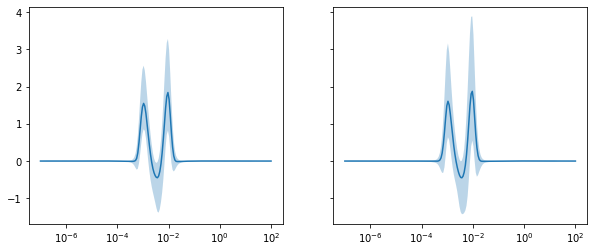

In [873]:
fig,axes = plt.subplots(1,2,figsize=(10,4),sharey=True)

g_lo = dr.drt(eval_tau=tau_plot,percentile=5)
g_hi = dr.drt(eval_tau=tau_plot,percentile=95)
    
axes[0].plot(tau_plot,dr.drt(tau_plot))
axes[0].fill_between(tau_plot,g_lo,g_hi,alpha=0.3)

suffix = file[file.find('_'):]
gres = pd.read_csv(os.path.join('bayes_results/old','Gout{}'.format(suffix)))
axes[1].plot(tau_plot,gres['gamma'])
axes[1].fill_between(tau_plot,gres['gamma_lo'],gres['gamma_hi'],alpha=0.3)

for ax in axes:
    ax.set_xscale('log')

## Truncated data

In [2]:
dr_trunc = drt.DRT(basis_freq=np.logspace(6,-2,81))
trunc_files = glob.glob('../data/simulated/Z_trunc*.csv')

# fit one file to generate A matrices
df = pd.read_csv(trunc_files[0])
Z = df['Zreal'] + 1j*df['Zimag']
dr_trunc.ridge_fit(df['Freq'].values,Z.values)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


NameError: name 'dr_trunc' is not defined

In [908]:
"MAP fits"
# tau for plotting
tau_plot = np.logspace(-7,2,200)
start = time.time()

for file in trunc_files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):]
    Zoutfile = os.path.join('map_results',f'Zout{suffix}')
    Goutfile = os.path.join('map_results',f'Gout{suffix}')
    pkl = os.path.join('map_results','obj{}.pkl'.format(suffix[:-4]))
    if file.split('_')[2]=='noiseless.csv':
        sigma_min=0.005
    else:
        sigma_min=0.002
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        df = pd.read_csv(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values
        # fit
        file_start = time.time()
        dr_trunc.map_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=False,sigma_min=sigma_min)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        # save results
        Z_pred = dr_trunc.predict(df['Freq'].values)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])
        Z_res['sigma_re'] = dr_trunc._opt_result['sigma_tot'][:len(df)]*dr_trunc._Z_scale
        Z_res['sigma_im'] = dr_trunc._opt_result['sigma_tot'][len(df):]*dr_trunc._Z_scale
        
        g_pred = dr_trunc.drt(eval_tau=tau_plot)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)
        
        # pickle the drt object for access to all other attributes
        save_pickle(dr_trunc,pkl)
        
print('================================')        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../data/simulated\Z_trunc_Macdonald_0.25.csv
-------------------------------
File fit time: 8.98 seconds
Dumped pickle to map_results\obj_trunc_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_trunc_Macdonald_1.0.csv
-------------------------------
File fit time: 2.17 seconds
Dumped pickle to map_results\obj_trunc_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_trunc_noiseless.csv
-------------------------------
File fit time: 10.80 seconds
Dumped pickle to map_results\obj_trunc_noiseless.pkl
Total fit time: 0.40 minutes


In [912]:
"MCMC sampling"
# tau for plotting
tau_plot = np.logspace(-7,2,200)
start = time.time()

for file in trunc_files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):]
    Zoutfile = os.path.join('bayes_results',f'Zout{suffix}')
    Goutfile = os.path.join('bayes_results',f'Gout{suffix}')
    pkl = os.path.join('bayes_results','obj{}.pkl'.format(suffix[:-4]))
    if file.split('_')[2]=='noiseless.csv':
        sigma_min=0.005
    else:
        sigma_min=0.002
        
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        df = pd.read_csv(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values
        
        # fit
        file_start = time.time()
        dr_trunc.bayes_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=True,sigma_min=sigma_min)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        Z_pred = dr_trunc.predict(df['Freq'].values)
        # Z credibility interval
        Z_lo = dr_trunc.predict(df['Freq'].values,percentile=2.5)
        Z_hi = dr_trunc.predict(df['Freq'].values,percentile=97.5)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag,Z_lo,Z_hi]).T,
                             columns=['freq','Zreal','Zimag','Zlo','Zhi'])
        Z_res['sigma_re'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[:len(df)]*dr._Z_scale
        Z_res['sigma_im'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[len(df):]*dr._Z_scale
        
        g_pred = dr_trunc.drt(eval_tau=tau_plot)
        # drt credibility interval
        g_lo = dr_trunc.drt(eval_tau=tau_plot,percentile=2.5)
        g_hi = dr_trunc.drt(eval_tau=tau_plot,percentile=97.5)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred,g_lo,g_hi]).T,
                             columns=['tau','gamma','gamma_lo','gamma_hi'])
        
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)
        
        # pickle the drt object for access to all other attributes
        save_pickle(dr_trunc,pkl)
        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../data/simulated\Z_trunc_Macdonald_0.25.csv
-------------------------------


../bayes-drt\drt.py:311: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


File fit time: 114.40 seconds


../bayes-drt\stan_models.py:7: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


Dumped pickle to bayes_results\obj_trunc_Macdonald_0.25.pkl
-------------------------------
../data/simulated\Z_trunc_Macdonald_1.0.csv
-------------------------------


File fit time: 61.44 seconds
Dumped pickle to bayes_results\obj_trunc_Macdonald_1.0.pkl
-------------------------------
../data/simulated\Z_trunc_noiseless.csv
-------------------------------


File fit time: 115.07 seconds
Dumped pickle to bayes_results\obj_trunc_noiseless.pkl
Total fit time: 4.88 minutes


File fit time: 0.00 seconds


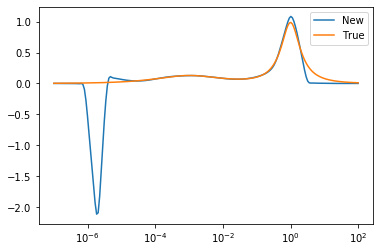

In [921]:
noise_level = 0.25
if noise_level > 0:
    suffix = f'Macdonald_{noise_level}'
else:
    suffix = 'noiseless'
pkl = load_pickle(f'bayes_results/obj_trunc_{suffix}.pkl')
file = f'../data/simulated/Z_trunc_{suffix}.csv'
df = pd.read_csv(file)
# df = df.sort_values('Freq')
Z = df['Zreal'].values + 1j*df['Zimag'].values
# fit
file_start = time.time()
# dr_trunc.map_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=False,outliers=False,max_iter=30e3,sigma_min=0.005)
print('File fit time: {:.2f} seconds'.format(time.time()-file_start))

suffix = file[file.find('_'):]
gres = pd.read_csv(os.path.join('map_results','Gout{}'.format(suffix)))

# old_res = pd.read_csv(os.path.join('map_results/old','Gout{}'.format(suffix)))

gfile = '../data/simulated/gamma_trunc.csv'
gtrue = pd.read_csv(gfile)

tau_plot = np.logspace(-7,2,200)
# plt.plot(tau_plot,dr_trunc.drt(tau_plot),label='run')
plt.plot(gres['tau'],gres['gamma'],label='New')
plt.plot(gtrue['tau'],gtrue['gamma'],label='True')

plt.xscale('log')
plt.legend()

In [3]:
dr_mcmc.tau

NameError: name 'dr_mcmc' is not defined

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000214623A9308>,
      dtype=object)

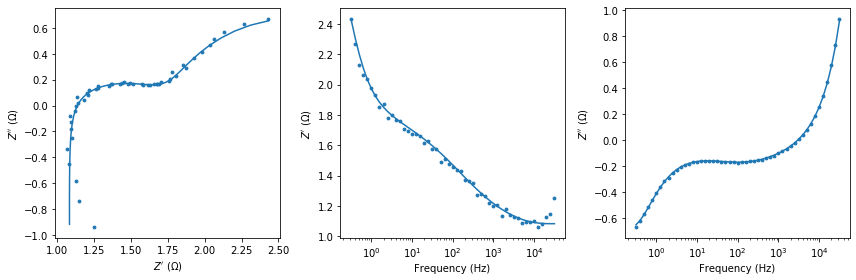

In [911]:
fig,axes = plt.subplots(1,3,figsize=(12,4))

gt.plot_full_eis(df,axes=axes,bode_cols=['Zreal','Zimag'])

Zres = pd.read_csv(os.path.join('map_results','Zout{}'.format(suffix)))
Zres['Freq'] = Zres['freq']
gt.plot_full_eis(Zres,axes=axes,bode_cols=['Zreal','Zimag'],plot_func='plot')

# Experimental data
## LIB data from DRTtools

In [6]:
lib_files = ['../data/experimental/DRTtools_LIB_data.txt',
             '../data/experimental/DRTtools_LIB_data_qtr.csv'
            ]

dr_lib = drt.DRT(basis_freq=np.logspace(4,-5,101))

# run ridge_fit to generate A matrices
lib_df = pd.read_csv(lib_files[0],sep='\t',header=None)
lib_df = pd.DataFrame(lib_df.values,columns=['Freq','Zreal','Zimag'])
Z_lib = lib_df['Zreal'] + 1j*lib_df['Zimag']
f = lib_df['Freq'].values
Z_lib = Z_lib
dr_lib.ridge_fit(f,Z_lib.values)

# finer tau for plotting
tau_plot = np.logspace(np.log10(np.min(dr_lib.tau)),np.log10(np.max(dr_lib.tau)),200)

../bayes-drt\drt.py:1035: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))
../bayes-drt\drt.py:1117: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A_main[n,:] = [quad(func,limits[0],limits[1],args=(w_n,t_m,epsilon),epsabs=1e-4)[0] for t_m in tau]
../bayes-drt\drt.py:311: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


In [7]:
"MAP fits"
start = time.time()

for file in lib_files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):]
    # strip file extension
    suffix = suffix[:suffix.find('.')]
    Zoutfile = os.path.join('map_results',f'Zout{suffix}.csv')
    Goutfile = os.path.join('map_results',f'Gout{suffix}.csv')
    pkl = os.path.join('map_results','obj{}.pkl'.format(suffix))
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        if file[-3:]=='txt':
            df = pd.read_csv(file,sep='\t',header=None)
            df = pd.DataFrame(df.values,columns=['Freq','Zreal','Zimag'])
        else:
            df = pd.read_csv(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values
        # fit
        file_start = time.time()
        # initializing from the ridge solution may be helpful for faster convergence for more complex spectra
        dr_lib.map_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=True,max_iter=30e3)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        # save results
        Z_pred = dr_lib.predict(df['Freq'].values)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])
        g_pred = dr_lib.drt(eval_tau=tau_plot)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)
        
        # pickle the drt object for access to all other attributes
        save_pickle(dr_lib,pkl)
        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../data/experimental/DRTtools_LIB_data.txt
-------------------------------
File fit time: 23.43 seconds
Dumped pickle to map_results\obj_LIB_data.pkl
-------------------------------
../data/experimental/DRTtools_LIB_data_qtr.csv
-------------------------------
File fit time: 11.20 seconds
Dumped pickle to map_results\obj_LIB_data_qtr.pkl
Total fit time: 0.58 minutes


In [9]:
"MCMC sampling"
# tau for plotting
tau_plot = np.logspace(np.log10(np.min(dr_lib.tau)),np.log10(np.max(dr_lib.tau)),200)
start = time.time()

for file in lib_files:
    print('-------------------------------')
    print(file)
    print('-------------------------------')
    suffix = file[file.find('_'):]
    # strip file extension
    suffix = suffix[:suffix.find('.')]
    Zoutfile = os.path.join('bayes_results',f'Zout{suffix}.csv')
    Goutfile = os.path.join('bayes_results',f'Gout{suffix}.csv')
    pkl = os.path.join('bayes_results','obj{}.pkl'.format(suffix))
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        if file[-3:]=='txt':
            df = pd.read_csv(file,sep='\t',header=None)
            df = pd.DataFrame(df.values,columns=['Freq','Zreal','Zimag'])
        else:
            df = pd.read_csv(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values
        
        # fit
        file_start = time.time()
        # initializing from the ridge solution may be helpful for sampling for more complex spectra
        dr_lib.bayes_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=True)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        
        Z_pred = dr_lib.predict(df['Freq'].values)
        # Z credibility interval
        Z_lo = dr_lib.predict(df['Freq'].values,percentile=2.5)
        Z_hi = dr_lib.predict(df['Freq'].values,percentile=97.5)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag,Z_lo,Z_hi]).T,
                             columns=['freq','Zreal','Zimag','Zlo','Zhi'])
        Z_res['sigma_re'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[:len(df)]*dr._Z_scale
        Z_res['sigma_im'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[len(df):]*dr._Z_scale
        
        g_pred = dr_lib.drt(eval_tau=tau_plot)
        # drt crediibility interval
        g_lo = dr_lib.drt(eval_tau=tau_plot,percentile=2.5)
        g_hi = dr_lib.drt(eval_tau=tau_plot,percentile=97.5)
        g_res = pd.DataFrame(np.array([tau_plot,g_pred,g_lo,g_hi]).T,
                             columns=['tau','gamma','gamma_lo','gamma_hi'])
        
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)
        
        # pickle the drt object for access to all other attributes
        save_pickle(dr_lib,pkl)
        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
../data/experimental/DRTtools_LIB_data.txt
-------------------------------


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 195.32 seconds


../bayes-drt\stan_models.py:7: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


Dumped pickle to bayes_results\obj_LIB_data.pkl
-------------------------------
../data/experimental/DRTtools_LIB_data_qtr.csv
-------------------------------


File fit time: 120.17 seconds
Dumped pickle to bayes_results\obj_LIB_data_qtr.pkl
Total fit time: 5.26 minutes


fit time: 0.0


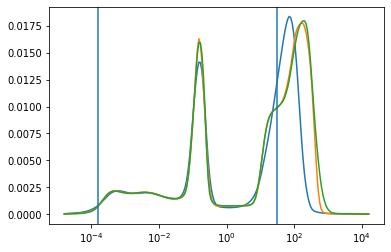

In [877]:
fig,ax = plt.subplots()

tau_plot = np.logspace(np.log10(np.min(dr_lib.tau)),np.log10(np.max(dr_lib.tau)),200)

file = '../data/experimental/DRTtools_LIB_data.txt'
lib_df = pd.read_csv(file,sep='\t',header=None)
lib_df = pd.DataFrame(lib_df.values,columns=['Freq','Zreal','Zimag'])
Z_lib = (lib_df['Zreal'] + 1j*lib_df['Zimag']).values

start = time.time()
# dr_lib.map_fit(lib_df['Freq'].values,Z_lib,dZ=False,init_from_ridge=True,max_iter=30e3,outliers=False,sigma_min=0.002)
print('fit time:',time.time()-start)
ax.plot(tau_plot,dr_lib.drt(tau_plot))

gres = pd.read_csv('bayes_results/Gout_LIB_data.csv')
ax.plot(gres['tau'],gres['gamma'])

oldres = pd.read_csv('bayes_results/old/Gout_LIB_data.csv')
ax.plot(oldres['tau'],oldres['gamma'])

# g_lib = drt_from_ecm(hist[3]['params'],dr_lib.tau)
# ax.plot(dr_lib.tau,g_lib,ls='--')

ax.axvline(1/(2*np.pi*np.min(lib_df['Freq'])))
ax.axvline(1/(2*np.pi*np.max(lib_df['Freq'])))
ax.set_xscale('log')

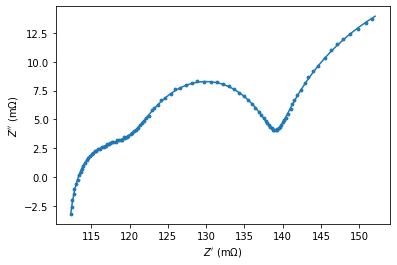

In [478]:
if '../../../misc_modules' not in sys.path:
    sys.path.append('../../../misc_modules')
import gamry_tools as gt

fig,ax = plt.subplots()
tdf = gt.construct_eis_df(f,Z_lib)
gt.plot_nyquist(tdf,ax=ax)

Z_pred = dr_lib.predict(lib_df['Freq'].values)
df_pred = gt.construct_eis_df(lib_df['Freq'],Z_pred)
gt.plot_nyquist(df_pred,ax=ax,plot_func='plot')

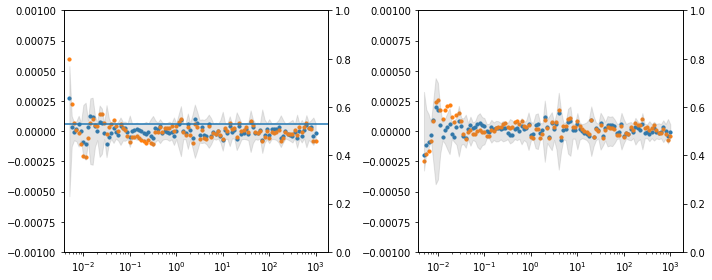

In [709]:
fig,axes = plt.subplots(1,2,figsize=(10,4))

Zres = pd.read_csv('bayes_results/Zout_LIB_data.csv')
real_cols = ['freq','Zreal','Zimag']
for col in real_cols:
    Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
    Zres[col] = np.real(Zres[col])
imag_cols = ['Zlo','Zhi']
for col in imag_cols:
    Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
axes[0].scatter(lib_df['Freq'],Zres['Zreal']-lib_df['Zreal'],s=10)
axes[1].scatter(lib_df['Freq'],Zres['Zimag']-lib_df['Zimag'],s=10)

Z_ecm = gt.Z_var_num_RC(lib_df['Freq'].values,**hist[3]['params'])

axes[0].scatter(lib_df['Freq'],Z_ecm.real-lib_df['Zreal'],s=10)
axes[1].scatter(lib_df['Freq'],Z_ecm.imag-lib_df['Zimag'],s=10)


sigma_re = dr_lib._opt_result['sigma_tot'][:len(lib_df)]*dr_lib._Z_scale
sigma_im = dr_lib._opt_result['sigma_tot'][len(lib_df):]*dr_lib._Z_scale
axes[0].fill_between(lib_df['Freq'],-3*sigma_re,3*sigma_re,alpha=0.2,color='gray')
axes[1].fill_between(lib_df['Freq'],-3*sigma_im,3*sigma_im,alpha=0.2,color='gray')
axes[0].axhline(3*0.002*dr_lib._Z_scale)

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlim(0.75*np.min(lib_df['Freq']),ax.get_xlim()[1])
    ax.set_ylim(-1e-3,1e-3)
    
    ax2 = ax.twinx()
#     ax2.plot(lib_df['Freq'],lib_df['Zreal'])
#     ax.plot(lib_df['Freq'],-lib_df['Zimag']*0.288*0.05)
#     ax.axhline(dr_lib._Z_scale*0.02)
    
fig.tight_layout()

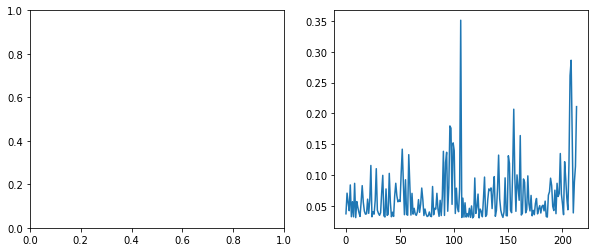

In [710]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
# axes[0].plot(dr_lib._opt_result['so_tau'])

axes[1].plot(dr_lib._opt_result['sigma_out_raw'])#*dr_lib._Z_scale)
# axes[1].set_ylim(-0.1,0.1)
# ax.axhline(0.005) #2.3e-6

In [514]:
.005*0.05

0.00025

In [602]:
dr_lib._opt_result

OrderedDict([('hfr_raw', array(0.10931624)),
             ('induc', array(7.45523036e-05)),
             ('beta',
              array([ 0.00185234,  0.00322751,  0.00438261,  0.00523988,  0.00675022,
                      0.00800183,  0.01025817,  0.01358267,  0.01842797,  0.02548035,
                      0.03504131,  0.04727902,  0.06136176,  0.07604108,  0.08982265,
                      0.10187613,  0.11184536,  0.11865695,  0.11960959,  0.11698689,
                      0.11294392,  0.10963208,  0.10747305,  0.10742468,  0.10799894,
                      0.10859569,  0.10969858,  0.11171271,  0.11247413,  0.10952706,
                      0.10323499,  0.09644218,  0.09088453,  0.08566015,  0.0802323 ,
                      0.07605732,  0.07553625,  0.07978719,  0.08846466,  0.10233974,
                      0.11742281,  0.27116381,  0.39292496,  0.50795363,  0.9703205 ,
                      0.93235946,  0.61260445,  0.33185065,  0.10354091, -0.00613124,
                      0.01

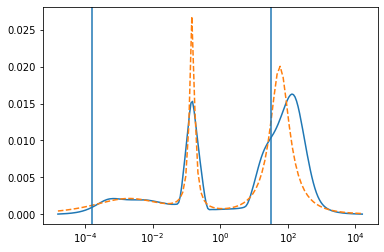

In [482]:
tau_plot = np.logspace(np.log10(np.min(dr_lib.tau)),np.log10(np.max(dr_lib.tau)),200)
fig,ax = plt.subplots()
# g_nscale = np.copy(dr_lib.drt(tau_plot))
ax.plot(tau_plot,dr_lib.drt(tau_plot))
# ax.plot(tau_plot,g_nscale)
# dr_lib.coef_ = dr_lib.

g_lib = drt_from_ecm(hist[3]['params'],dr_lib.tau)
ax.plot(dr_lib.tau,g_lib,ls='--')

ax.axvline(1/(2*np.pi*np.min(lib_df['Freq'])))
ax.axvline(1/(2*np.pi*np.max(lib_df['Freq'])))
ax.set_xscale('log')

## Protonic ceramic microelectrode

In [14]:
tco_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
tco_df = gt.read_eis_zdata(tco_file)

dr_tco = drt.DRT(basis_freq=np.logspace(7,-3,101))

# run ridge_fit to generate A matrices
Z_tco = tco_df['Zreal'] + 1j*tco_df['Zimag']
f = tco_df['Freq'].values
dr_tco.ridge_fit(f,Z_tco.values)

# finer tau for plotting
tau_plot_tco = np.logspace(np.log10(np.min(dr_tco.tau)),np.log10(np.max(dr_tco.tau)),200)

In [15]:
np.min(tau_plot_tco),np.max(tau_plot_tco)

(1.591549430918952e-08, 159.15494309189538)

In [17]:
"MAP fits"
start = time.time()
file = tco_file

for outliers in [True,False]:
    print('-------------------------------')
    print(f'Outliers={outliers}')
    print('-------------------------------')
    suffix = '_PDAC'
    if outliers:
        suffix += '_outliers'
    Zoutfile = os.path.join('map_results',f'Zout{suffix}.csv')
    Goutfile = os.path.join('map_results',f'Gout{suffix}.csv')
    pkl = os.path.join('map_results','obj{}.pkl'.format(suffix))
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        df = gt.read_eis_zdata(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values
        # fit
        file_start = time.time()
        # initializing from the ridge solution may be helpful for faster convergence for more complex spectra
        dr_tco.map_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=True,max_iter=30e3,outliers=outliers)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))
        # save results
        Z_pred = dr_tco.predict(df['Freq'].values)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag]).T,columns=['freq','Zreal','Zimag'])
        g_pred = dr_tco.drt(eval_tau=tau_plot_tco)
        g_res = pd.DataFrame(np.array([tau_plot_tco,g_pred]).T,
                             columns=['tau','gamma'])
        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)
        
        # pickle the drt object for access to all other attributes
        save_pickle(dr_tco,pkl)
        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
Outliers=True
-------------------------------
File fit time: 28.22 seconds
Dumped pickle to map_results\obj_PDAC_outliers.pkl
-------------------------------
Outliers=False
-------------------------------
File fit time: 13.70 seconds
Dumped pickle to map_results\obj_PDAC.pkl
Total fit time: 0.70 minutes


In [28]:
"MCMC sampling"
# tau for plotting
start = time.time()

file = tco_file
for outliers in [True,False]:
    print('-------------------------------')
    print(f'Outliers={outliers}')
    print('-------------------------------')
    suffix = '_PDAC'
    if outliers:
        suffix += '_outliers'
        
    Zoutfile = os.path.join('bayes_results',f'Zout{suffix}.csv')
    Goutfile = os.path.join('bayes_results',f'Gout{suffix}.csv')
    pkl = os.path.join('bayes_results','obj{}.pkl'.format(suffix))
    
    if os.path.exists(Zoutfile) and os.path.exists(Goutfile):
        print('Already ran')
    else:
        df = gt.read_eis_zdata(file)
        Z = df['Zreal'].values + 1j*df['Zimag'].values

        # fit
        file_start = time.time()
        # initializing from the ridge solution may be helpful for sampling for more complex spectra
        dr_tco.bayes_fit(df['Freq'].values,Z,dZ=False,init_from_ridge=True,outliers=outliers)
        print('File fit time: {:.2f} seconds'.format(time.time()-file_start))

        Z_pred = dr_tco.predict(df['Freq'].values)
        # Z credibility interval
        Z_lo = dr_tco.predict(df['Freq'].values,percentile=2.5)
        Z_hi = dr_tco.predict(df['Freq'].values,percentile=97.5)
        Z_res = pd.DataFrame(np.array([df['Freq'],Z_pred.real,Z_pred.imag,Z_lo,Z_hi]).T,
                             columns=['freq','Zreal','Zimag','Zlo','Zhi'])
        Z_res['sigma_re'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[:len(df)]*dr._Z_scale
        Z_res['sigma_im'] = np.mean(dr._sample_result['sigma_tot'],axis=0)[len(df):]*dr._Z_scale

        g_pred = dr_tco.drt(eval_tau=tau_plot_tco)
        # drt crediibility interval
        g_lo = dr_tco.drt(eval_tau=tau_plot_tco,percentile=2.5)
        g_hi = dr_tco.drt(eval_tau=tau_plot_tco,percentile=97.5)
        g_res = pd.DataFrame(np.array([tau_plot_tco,g_pred,g_lo,g_hi]).T,
                             columns=['tau','gamma','gamma_lo','gamma_hi'])

        Z_res.to_csv(Zoutfile,index=False)
        g_res.to_csv(Goutfile,index=False)

        # pickle the drt object for access to all other attributes
        save_pickle(dr_tco,pkl)
        
print('Total fit time: {:.2f} minutes'.format((time.time()-start)/60))

-------------------------------
Outliers=True
-------------------------------


../bayes-drt\drt.py:311: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


File fit time: 222.17 seconds
Dumped pickle to bayes_results\obj_PDAC_outliers.pkl
-------------------------------
Outliers=False
-------------------------------
Already ran
Total fit time: 3.71 minutes


../bayes-drt\stan_models.py:7: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


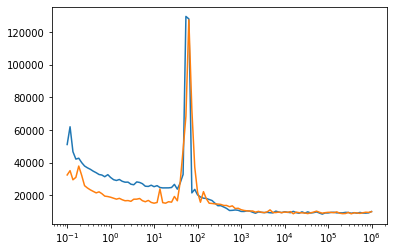

In [29]:
dr_out = load_pickle('bayes_results/obj_PDAC_outliers.pkl')
sigma_re,sigma_im = dr_out.predict_err_scale(dr_out.f_train)

fig,ax = plt.subplots()
ax.plot(dr_out.f_train,sigma_re)
ax.plot(dr_out.f_train,sigma_im)
ax.set_xscale('log')

In [22]:
np.mean(dr_out._sample_result['sigma_out'],axis=0)

ValueError: No parameter sigma_out

In [ ]:
dr_lib = drt.DRT(basis_freq=np.logspace(4,-5,101))
# finer tau for plotting
tau_plot = np.logspace(np.log10(np.min(dr_lib.tau)),np.log10(np.max(dr_lib.tau)),200)

# run ridge_fit to generate A matrices
Z_lib = lib_df['Zreal'] + 1j*lib_df['Zimag']
f = lib_df['Freq'].values
Z_lib = Z_lib
dr_lib.ridge_fit(f,Z_lib.values)

../bayes-drt\drt.py:311: UserWarning: Hyperparametric solution did not converge within 20 iterations
  warnings.warn(f'Hyperparametric solution did not converge within {max_iter} iterations')


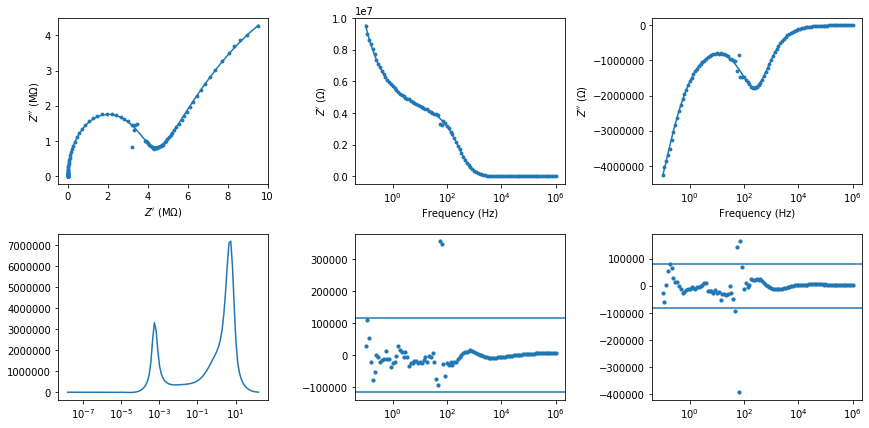

In [369]:
from scipy.stats import iqr

dr_tco.ridge_fit(tco_df['Freq'].values,Z_tco,dZ=True,beta=3,lambda_0=1e-2)

fig,axes = plt.subplots(2,3,figsize=(12,6))

gt.plot_full_eis(tco_df,axes=axes[0],bode_cols=['Zreal','Zimag'])

Z_pred = dr_tco.predict(tco_df['Freq'].values)
df_pred = gt.construct_eis_df(tco_df['Freq'],Z_pred)
gt.plot_full_eis(df_pred,axes=axes[0],bode_cols=['Zreal','Zimag'],plot_func='plot')

axes[1,0].plot(dr_tco.tau,dr_tco.drt())
re_err = Z_pred.real - tco_df['Zreal']
im_err = Z_pred.imag - tco_df['Zimag']
axes[1,1].scatter(tco_df['Freq'],re_err,s=10)
axes[1,2].scatter(tco_df['Freq'],im_err,s=10)
# axes[1,1].axhline(-3*np.std(re_err))
axes[1,1].axhline(-5*iqr(re_err))
axes[1,1].axhline(5*iqr(re_err))
# axes[1,1].axhline(3*np.std(re_err))

axes[1,2].axhline(-5*iqr(im_err))
axes[1,2].axhline(5*iqr(im_err))

for ax in axes[1]:
    ax.set_xscale('log')

In [862]:
Z_tco = (tco_df['Zreal'] + 1j*tco_df['Zimag']).values
start = time.time()
dr_tco.map_fit(tco_df['Freq'].values,Z_tco,dZ=False,init_from_ridge=True,outliers=True,max_iter=30e3,sigma_min=0.002)
print('fit time:',time.time() - start)

fit time: 20.9215247631073


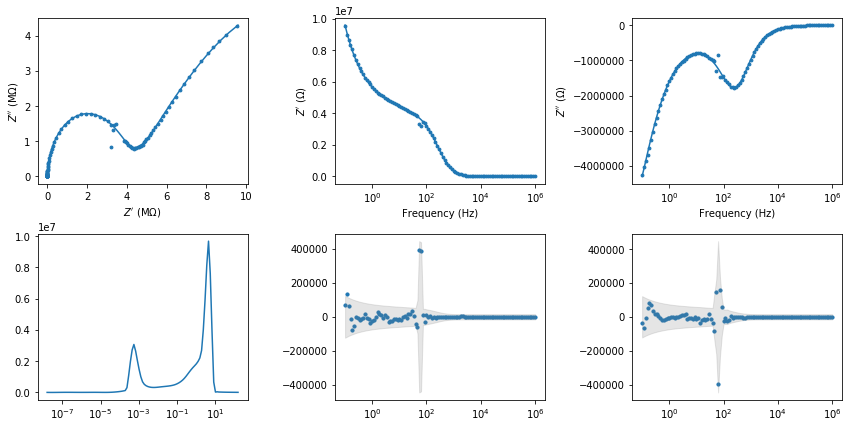

In [863]:
fig,axes = plt.subplots(2,3,figsize=(12,6))

gt.plot_full_eis(tco_df,axes=axes[0],bode_cols=['Zreal','Zimag'])

Z_pred = dr_tco.predict(tco_df['Freq'].values)
df_pred = gt.construct_eis_df(tco_df['Freq'],Z_pred)
gt.plot_full_eis(df_pred,axes=axes[0],bode_cols=['Zreal','Zimag'],plot_func='plot')

axes[1,0].plot(dr_tco.tau,dr_tco.drt())
re_err = Z_pred.real - tco_df['Zreal']
im_err = Z_pred.imag - tco_df['Zimag']
axes[1,1].scatter(tco_df['Freq'],re_err,s=10)
axes[1,2].scatter(tco_df['Freq'],im_err,s=10)

sigma_re = dr_tco._opt_result['sigma_tot'][:len(tco_df)]*dr_tco._Z_scale
sigma_im = dr_tco._opt_result['sigma_tot'][len(tco_df):]*dr_tco._Z_scale
axes[1,1].fill_between(tco_df['Freq'],-3*sigma_re,3*sigma_re,alpha=0.2,color='gray')
axes[1,2].fill_between(tco_df['Freq'],-3*sigma_im,3*sigma_im,alpha=0.2,color='gray')

# axes[1,1].axhline(-3*np.std(re_err))
# axes[1,1].axhline(-5*iqr(re_err))
# axes[1,1].axhline(5*iqr(re_err))
# axes[1,1].axhline(3*np.std(re_err))

# axes[1,2].axhline(-5*iqr(im_err))
# axes[1,2].axhline(5*iqr(im_err))

for ax in axes[1]:
    ax.set_xscale('log')

In [864]:
cdf = tco_df[~tco_df.index.isin([61,62,63,64])]
Zc = cdf['Zreal'] + 1j*cdf['Zimag']
score = dr_tco.score(cdf['Freq'].values,Zc.values)
print('{:.2e}'.format(score))

8.65e+08


In [746]:
def zarc_drt(t,t0,n):
    "Analytical DRT of ZARC"
    return (1/(2*np.pi))*np.sin((1-n)*np.pi)/(np.cosh(n*np.log(t/t0))-np.cos((1-n)*np.pi))

def ger_drt(t,t0):
    "Analytical DRT of Gerischer"
    t = np.sort(t)
    tl = t[t<=t0]
    th = t[t>t0]
    out = np.zeros(len(t))
    out[:len(tl)] = (1/np.pi)*np.sqrt(tl/(t0-tl))
    out[len(tl):] = 0
    return out

(0, 10000000.0)

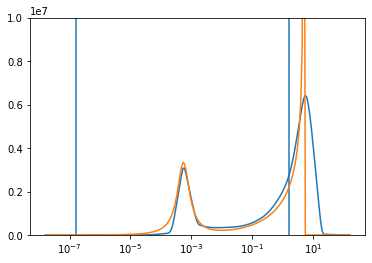

In [764]:
tau_plot = np.logspace(np.log10(np.min(dr_tco.tau)),np.log10(np.max(dr_tco.tau)),200)
plt.plot(tau_plot,dr_tco.drt(tau_plot))
plt.xscale('log')
plt.axvline(1/(2*np.pi*np.min(tco_df['Freq'])))
plt.axvline(1/(2*np.pi*np.max(tco_df['Freq'])))

# ecm_drt = zarc_drt(dr_tco.tau,)
ecm_drt = 5e6*zarc_drt(tau_plot,0.55e-3,0.85) \
    + 10e6*ger_drt(tau_plot,5)
plt.plot(tau_plot,ecm_drt)

plt.ylim(0,1e7)

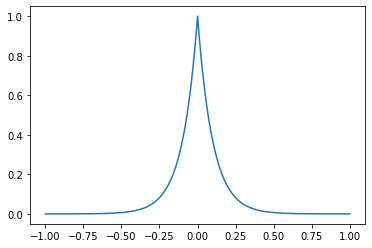

In [655]:
x= np.arange(-1,1,0.001)
scale = 0.1
plt.plot(x,np.exp(-np.abs(x)/scale))

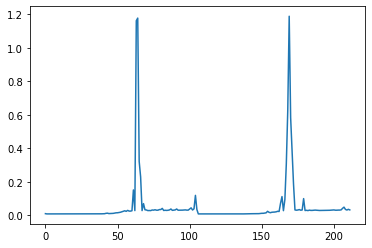

In [744]:
plt.plot(dr_tco._opt_result['sigma_out_raw'])#-dr_tco._opt_result['sigma_out'])
# plt.plot(re_err/dr_tco._Z_scale)
# plt.axhline(0.01)

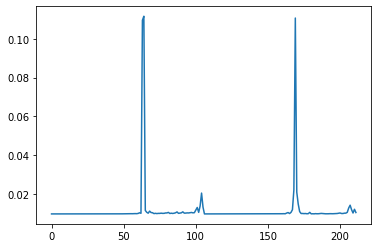

In [307]:
plt.plot(dr_tco._opt_result['sigma_tot'])

In [694]:
dr_tco._opt_result

OrderedDict([('hfr_raw', array(2.21535578e-05)),
             ('induc', array(1.80043104e-11)),
             ('beta',
              array([-6.87397307e-04, -1.02471491e-03, -1.21305592e-03, -1.21155190e-03,
                     -1.06425950e-03, -8.16437368e-04, -5.23541103e-04, -2.40716429e-04,
                     -3.74625646e-06,  1.75332735e-04,  2.93177967e-04,  3.51496545e-04,
                      3.54153187e-04,  3.13897338e-04,  2.48119294e-04,  1.69116256e-04,
                      8.17459197e-05, -1.13956822e-05, -1.00740032e-04, -1.76646102e-04,
                     -2.26106597e-04, -2.34752460e-04, -1.92899381e-04, -9.94934968e-05,
                      2.91319863e-05,  1.69108507e-04,  2.94818650e-04,  3.81162765e-04,
                      4.02749350e-04,  3.39332267e-04,  1.88173282e-04, -3.16663757e-05,
                     -2.69047636e-04, -4.48656749e-04, -4.79170940e-04, -2.62045389e-04,
                      2.86789649e-04,  1.22080704e-03,  2.54885843e-03,  4.235724